# TTA Debug Notebook (Aligned with run_tta.py)
This notebook reuses the same pipeline + TTA flow as `debug_tests/run_tta.py` and runs on real data/model.


In [1]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
import torch.nn as nn
from skimage.transform import resize

ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
SAM2_ROOT = ROOT.parent / "sam2"
if SAM2_ROOT.exists() and str(SAM2_ROOT) not in sys.path:
    sys.path.insert(0, str(SAM2_ROOT))

from configs.pipeline_config import load_pipeline_config
from datasets.dataset import load_dataset
from debug_tests.run_tta import (
    _load_constants,
    run_segmentation_with_info,
    load_tta_config,
)
from image_processings.tta import (
    TTALossWeights,
    run_tta_from_pool,
    default_multi_view_augment,
    apply_lora_to_mask_decoder,
    prepare_prompts_for_model,
    prepare_prompts_for_vis,
)
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

%matplotlib inline

def _to_uint8(image):
    if image.dtype == np.uint8:
        return image
    img = image.astype(np.float32)
    if img.max() > img.min():
        img = (img - img.min()) / (img.max() - img.min())
    return (img * 255).clip(0, 255).astype(np.uint8)

def _overlay(image, mask, color=(255, 0, 0), alpha=0.4):
    base = _to_uint8(image).copy()
    if base.ndim == 2:
        base = np.repeat(base[..., None], 3, axis=2)
    mask_arr = mask
    if mask_arr.shape[:2] != base.shape[:2]:
        mask_arr = resize(mask_arr.astype(float), base.shape[:2], order=0, preserve_range=True, anti_aliasing=False) > 0.5
    overlay = base.copy()
    overlay[mask_arr] = color
    return (base * (1 - alpha) + overlay * alpha).astype(np.uint8)

def _draw_points(ax, points, labels):
    if points is None or labels is None:
        return
    if len(points) == 0:
        return
    pts = np.asarray(points)
    labs = np.asarray(labels)
    pos = pts[labs == 1]
    neg = pts[labs == 0]
    if len(pos):
        ax.scatter(pos[:, 0], pos[:, 1], s=30, c="lime", marker="+")
    if len(neg):
        ax.scatter(neg[:, 0], neg[:, 1], s=30, c="red", marker="x")

def _show_heatmap(ax, heat, title):
    if hasattr(heat, "detach"):
        heat = heat.detach().cpu().numpy()
    if heat.ndim == 3 and heat.shape[0] == 1:
        heat = heat[0]
    ax.imshow(heat, cmap="magma")
    ax.set_title(title)
    ax.axis("off")


In [2]:
# Load configs (same as run_tta.py)
constants = _load_constants()
pipeline_cfg = load_pipeline_config(ROOT / constants["pipeline_cfg"])
tta_cfg = load_tta_config(ROOT / "configs" / "tta_config.json")

# Load dataset (same utility as run_tta.py)
images, gt_masks, image_names = load_dataset(
    pipeline_cfg.dataset.name,
    data_root=None,
    target_long_edge=pipeline_cfg.dataset.target_long_edge,
    return_paths=True,
)
sample_idx = 0
image = images[sample_idx]
gt_mask = gt_masks[sample_idx]
sample_name = Path(image_names[sample_idx]).stem if image_names else f"sample_{sample_idx:04d}"



In [3]:
# Build model + predictor (same as run_tta.py)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = build_sam2(constants["model_cfg"], constants["checkpoint"], device=device)
lora_cfg = tta_cfg.get("lora", {})
if lora_cfg.get("target") == "mask_decoder":
    apply_lora_to_mask_decoder(
        model,
        r=int(lora_cfg.get("rank", 4)),
        lora_alpha=int(lora_cfg.get("alpha", 8)),
        lora_dropout=float(lora_cfg.get("dropout", 0.0)),
        target_modules=lora_cfg.get("target_modules"),
    )
predictor = SAM2ImagePredictor(model)
predictor.model.to(device)
model.train()

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = None
if trainable_params:
    opt_cfg = tta_cfg.get("optimizer", {})
    optimizer = torch.optim.AdamW(
        trainable_params,
        lr=float(opt_cfg.get("lr", 1e-4)),
        weight_decay=float(opt_cfg.get("weight_decay", 0.0)),
    )
max_grad_norm = float(tta_cfg.get("optimizer", {}).get("max_grad_norm", 1.0))


/app/SAM2_proj/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:773.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/app/SAM2_proj/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:558.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/app/SAM2_proj/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:775.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/app/SAM2_proj/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Expected query, key and value to all be of dtype: {Half, BFloat16}. Got Query dtype: float, Key dtype: float, and 

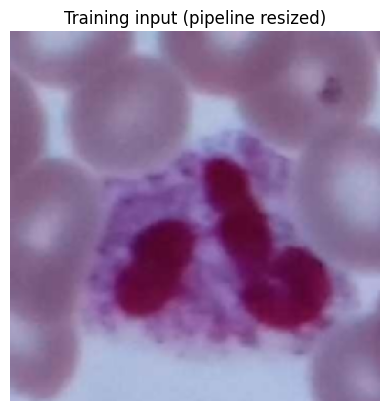

In [4]:
# 1) Run pipeline once to get prompts + mask pool (aligned with run_tta.py)
base_mask, history, vis_image, segments, info = run_segmentation_with_info(image, pipeline_cfg, predictor)
final_prompts = history[-1].prompts
mask_prompt_source = tta_cfg.get("prompt", {}).get("mask_prompt_source", "none")
if mask_prompt_source in {"pipeline_mask_prompt", "mask_prompt"}:
    tta_mask_input = final_prompts.mask_prompt
elif mask_prompt_source in {"pipeline_low_res", "low_res"}:
    tta_mask_input = final_prompts.low_res_mask
else:
    tta_mask_input = None

prompts = {
    "point_coords": final_prompts.points,
    "point_labels": final_prompts.labels,
    "box": None,
    "mask_input": tta_mask_input,
    "multimask_output": pipeline_cfg.sam.multimask_output,
}


plt.imshow(_to_uint8(vis_image))
plt.title("Training input (pipeline resized)")
plt.axis("off")
plt.show()


# Part 1: pipeline with best output

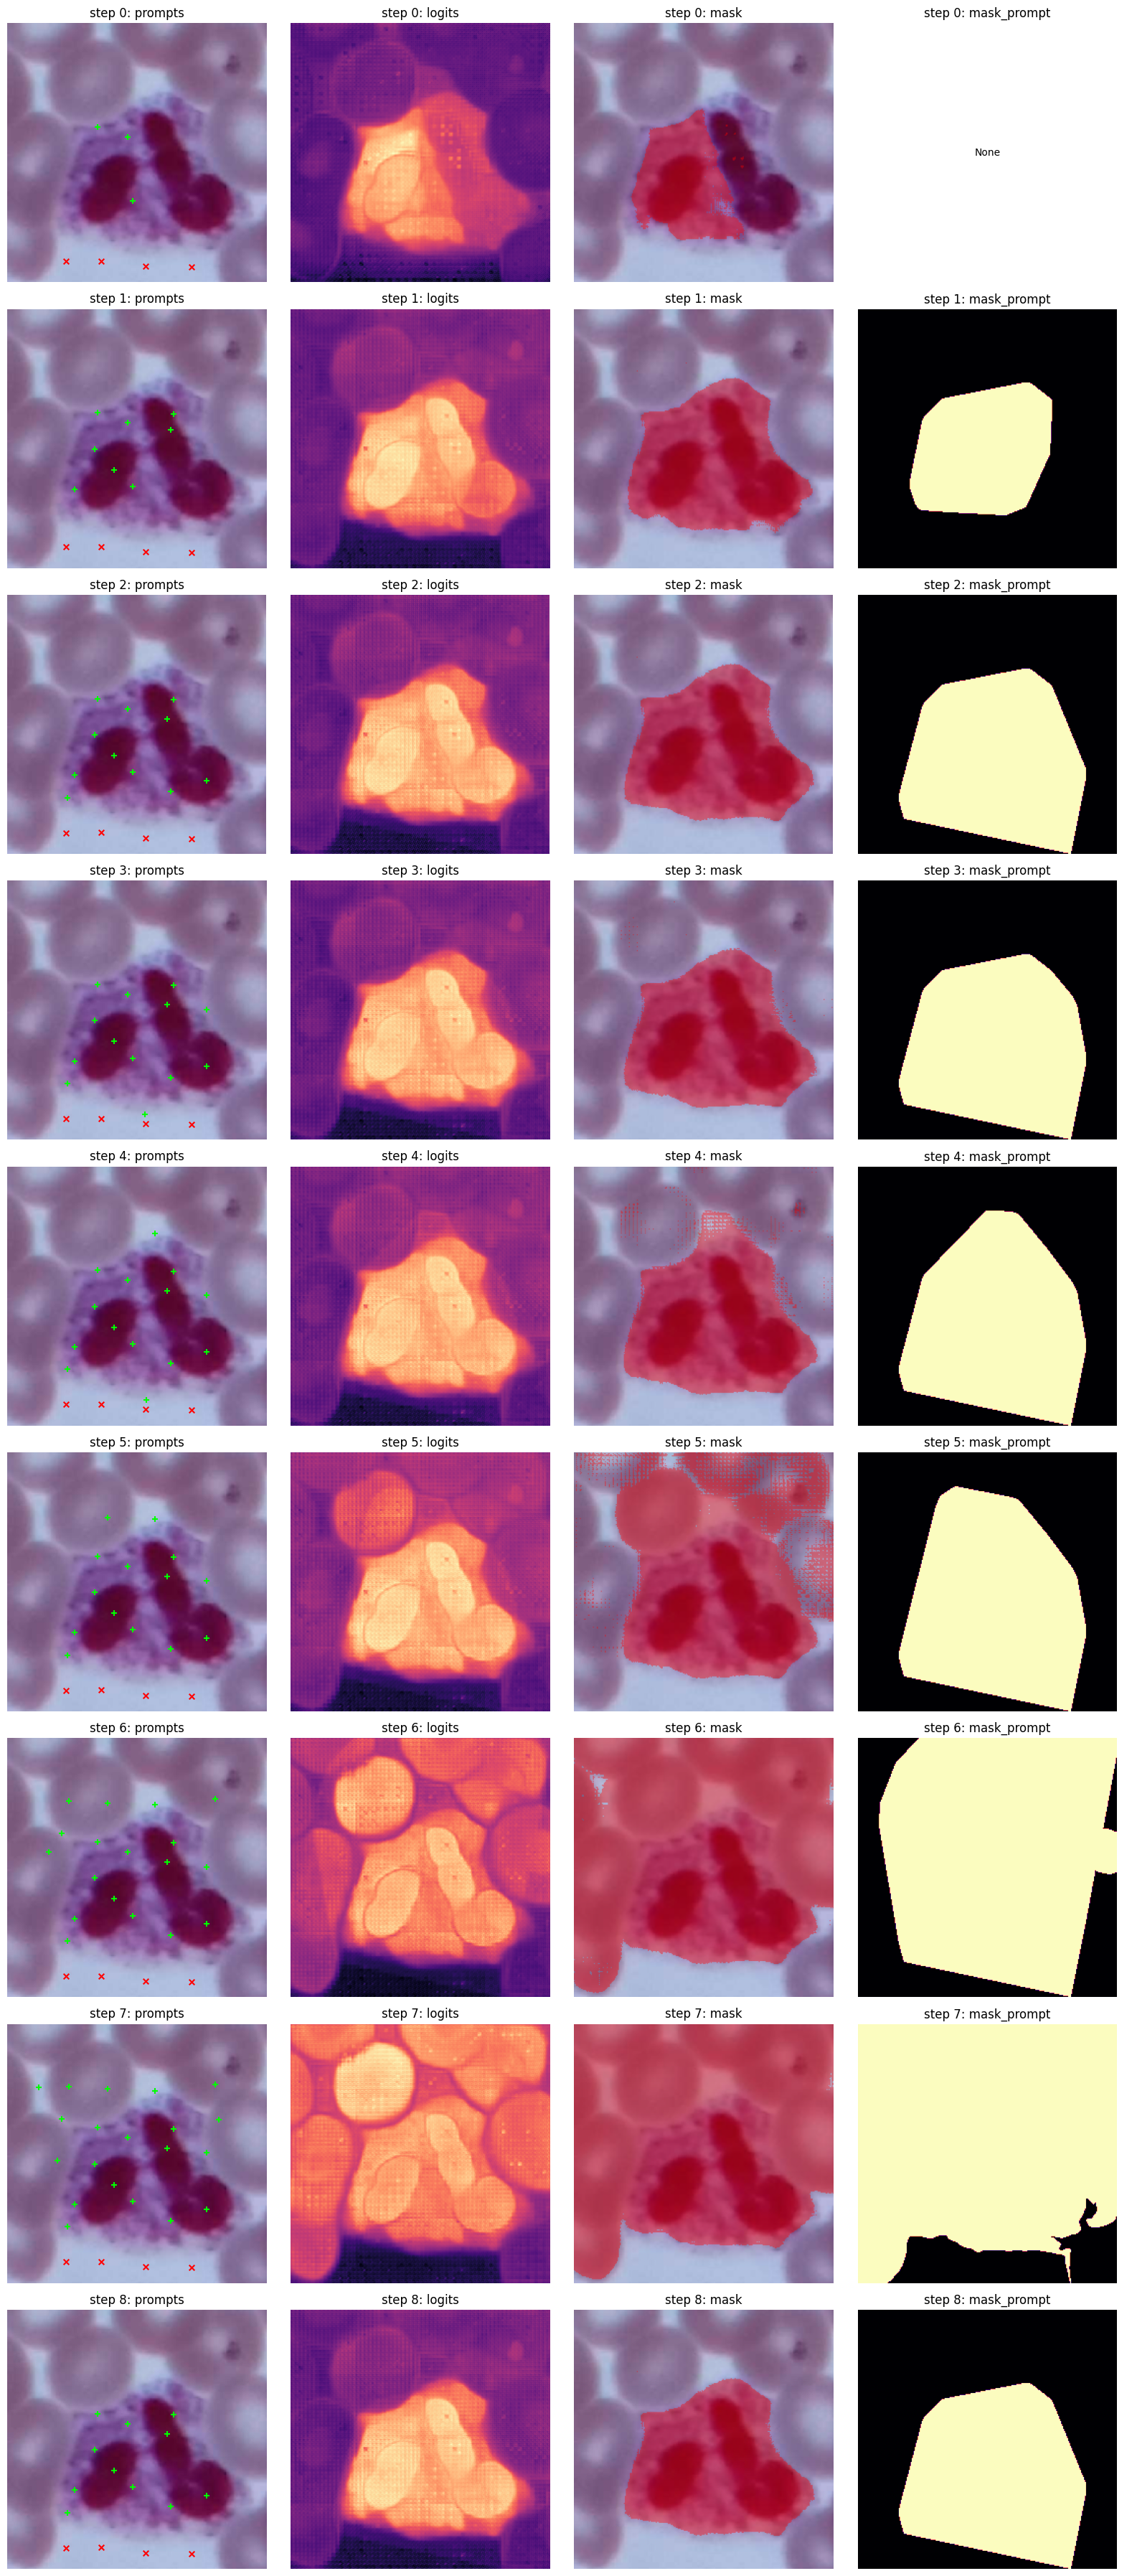

In [5]:
# Pipeline evolution: per-step prompts + logits + mask + mask_prompt
max_steps = None  # set an int to limit, e.g., 6
steps = history if max_steps is None else history[:max_steps]

num_steps = len(steps)
fig, axes = plt.subplots(num_steps, 4, figsize=(16, 4 * num_steps))
if num_steps == 1:
    axes = np.expand_dims(axes, axis=0)

for row, step in enumerate(steps):
    # Image + prompts
    axes[row, 0].imshow(_to_uint8(vis_image))
    _draw_points(axes[row, 0], step.prompts.points, step.prompts.labels)
    axes[row, 0].set_title(f"step {row}: prompts")
    axes[row, 0].axis("off")

    # Logits heatmap
    _show_heatmap(axes[row, 1], step.logits, f"step {row}: logits")

    # Mask overlay
    overlay = _overlay(vis_image, step.mask)
    axes[row, 2].imshow(overlay)
    axes[row, 2].set_title(f"step {row}: mask")
    axes[row, 2].axis("off")

    # Mask prompt (if any)
    mask_prompt = step.prompts.mask_prompt
    if mask_prompt is not None:
        _show_heatmap(axes[row, 3], mask_prompt, f"step {row}: mask_prompt")
    else:
        axes[row, 3].text(0.5, 0.5, "None", ha="center", va="center")
        axes[row, 3].set_title(f"step {row}: mask_prompt")
        axes[row, 3].axis("off")

plt.tight_layout()
plt.show()


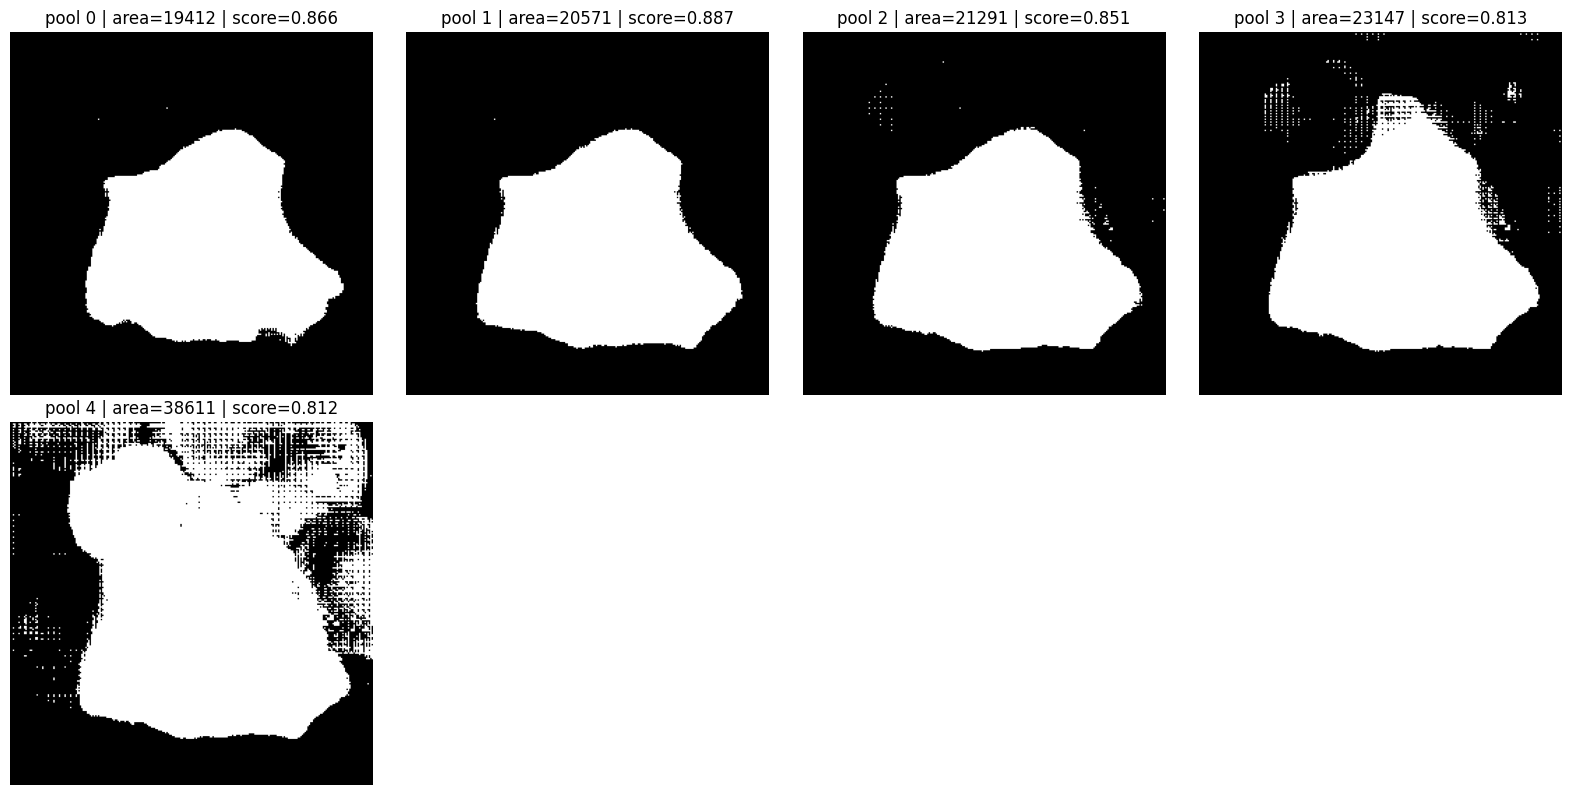

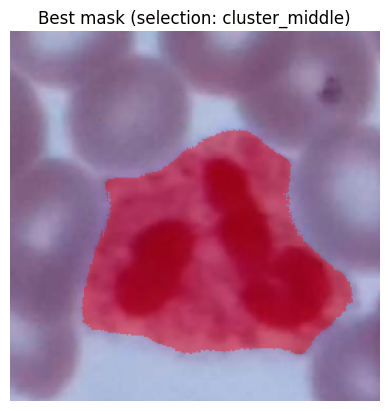

In [6]:
# Mask pool overview + best mask
pool = info.get_mask_pool()
areas = []
for entry in pool:
    mask = entry.get("mask")
    area = float(mask.sum()) if mask is not None else 0.0
    areas.append(area)

# Sort pool by area to show the interval progression
sorted_idx = np.argsort(areas)
sorted_pool = [pool[i] for i in sorted_idx]

num = len(sorted_pool)
cols = min(4, max(1, num))
rows = int(np.ceil(num / cols)) if num else 1
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = np.atleast_1d(axes).reshape(rows, cols)

for i, entry in enumerate(sorted_pool):
    r, c = divmod(i, cols)
    mask = entry.get("mask")
    score = entry.get("score")
    title = f"pool {i} | area={int(areas[sorted_idx[i]])}"
    if score is not None:
        title += f" | score={score:.3f}"
    axes[r, c].imshow(mask, cmap="gray")
    axes[r, c].set_title(title)
    axes[r, c].axis("off")

# Hide extra axes
for j in range(num, rows * cols):
    r, c = divmod(j, cols)
    axes[r, c].axis("off")

plt.tight_layout()
plt.show()

# Best mask (final selection)
best_overlay = _overlay(vis_image, base_mask)
plt.imshow(best_overlay)
plt.title(f"Best mask (selection: {info.selection_metadata.get('method')})")
plt.axis("off")
plt.show()


# Part 2: Supervision Using Mask Pool


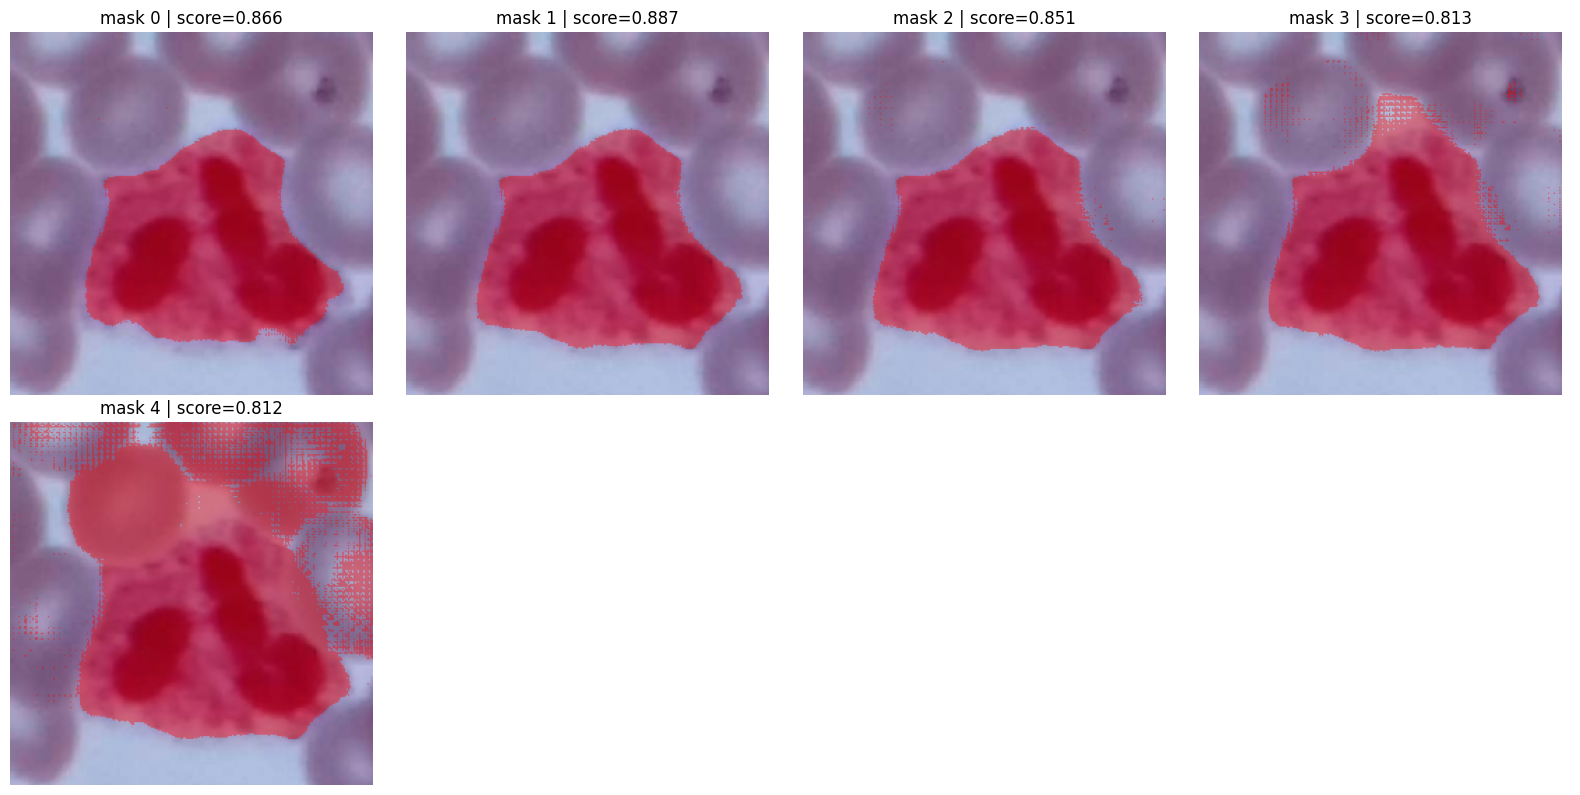

In [7]:
# Part 2: mask pool supervision visualisation (N x 4)
pool = info.get_mask_pool()
if not pool:
    print('mask pool is empty')
else:
    num = len(pool)
    cols = 4
    rows = int(np.ceil(num / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = np.atleast_1d(axes).reshape(rows, cols)

    for i, entry in enumerate(pool):
        r, c = divmod(i, cols)
        mask = entry.get('mask')
        score = entry.get('score')
        logits = entry.get('logits')
        title = f'mask {i}'
        if score is not None:
            title += f' | score={float(score):.3f}'
        overlay = _overlay(vis_image, mask)
        axes[r, c].imshow(overlay)
        axes[r, c].set_title(title)
        axes[r, c].axis('off')

    for j in range(num, rows * cols):
        r, c = divmod(j, cols)
        axes[r, c].axis('off')

    plt.tight_layout()
    plt.show()


# Part 3 consistance loss

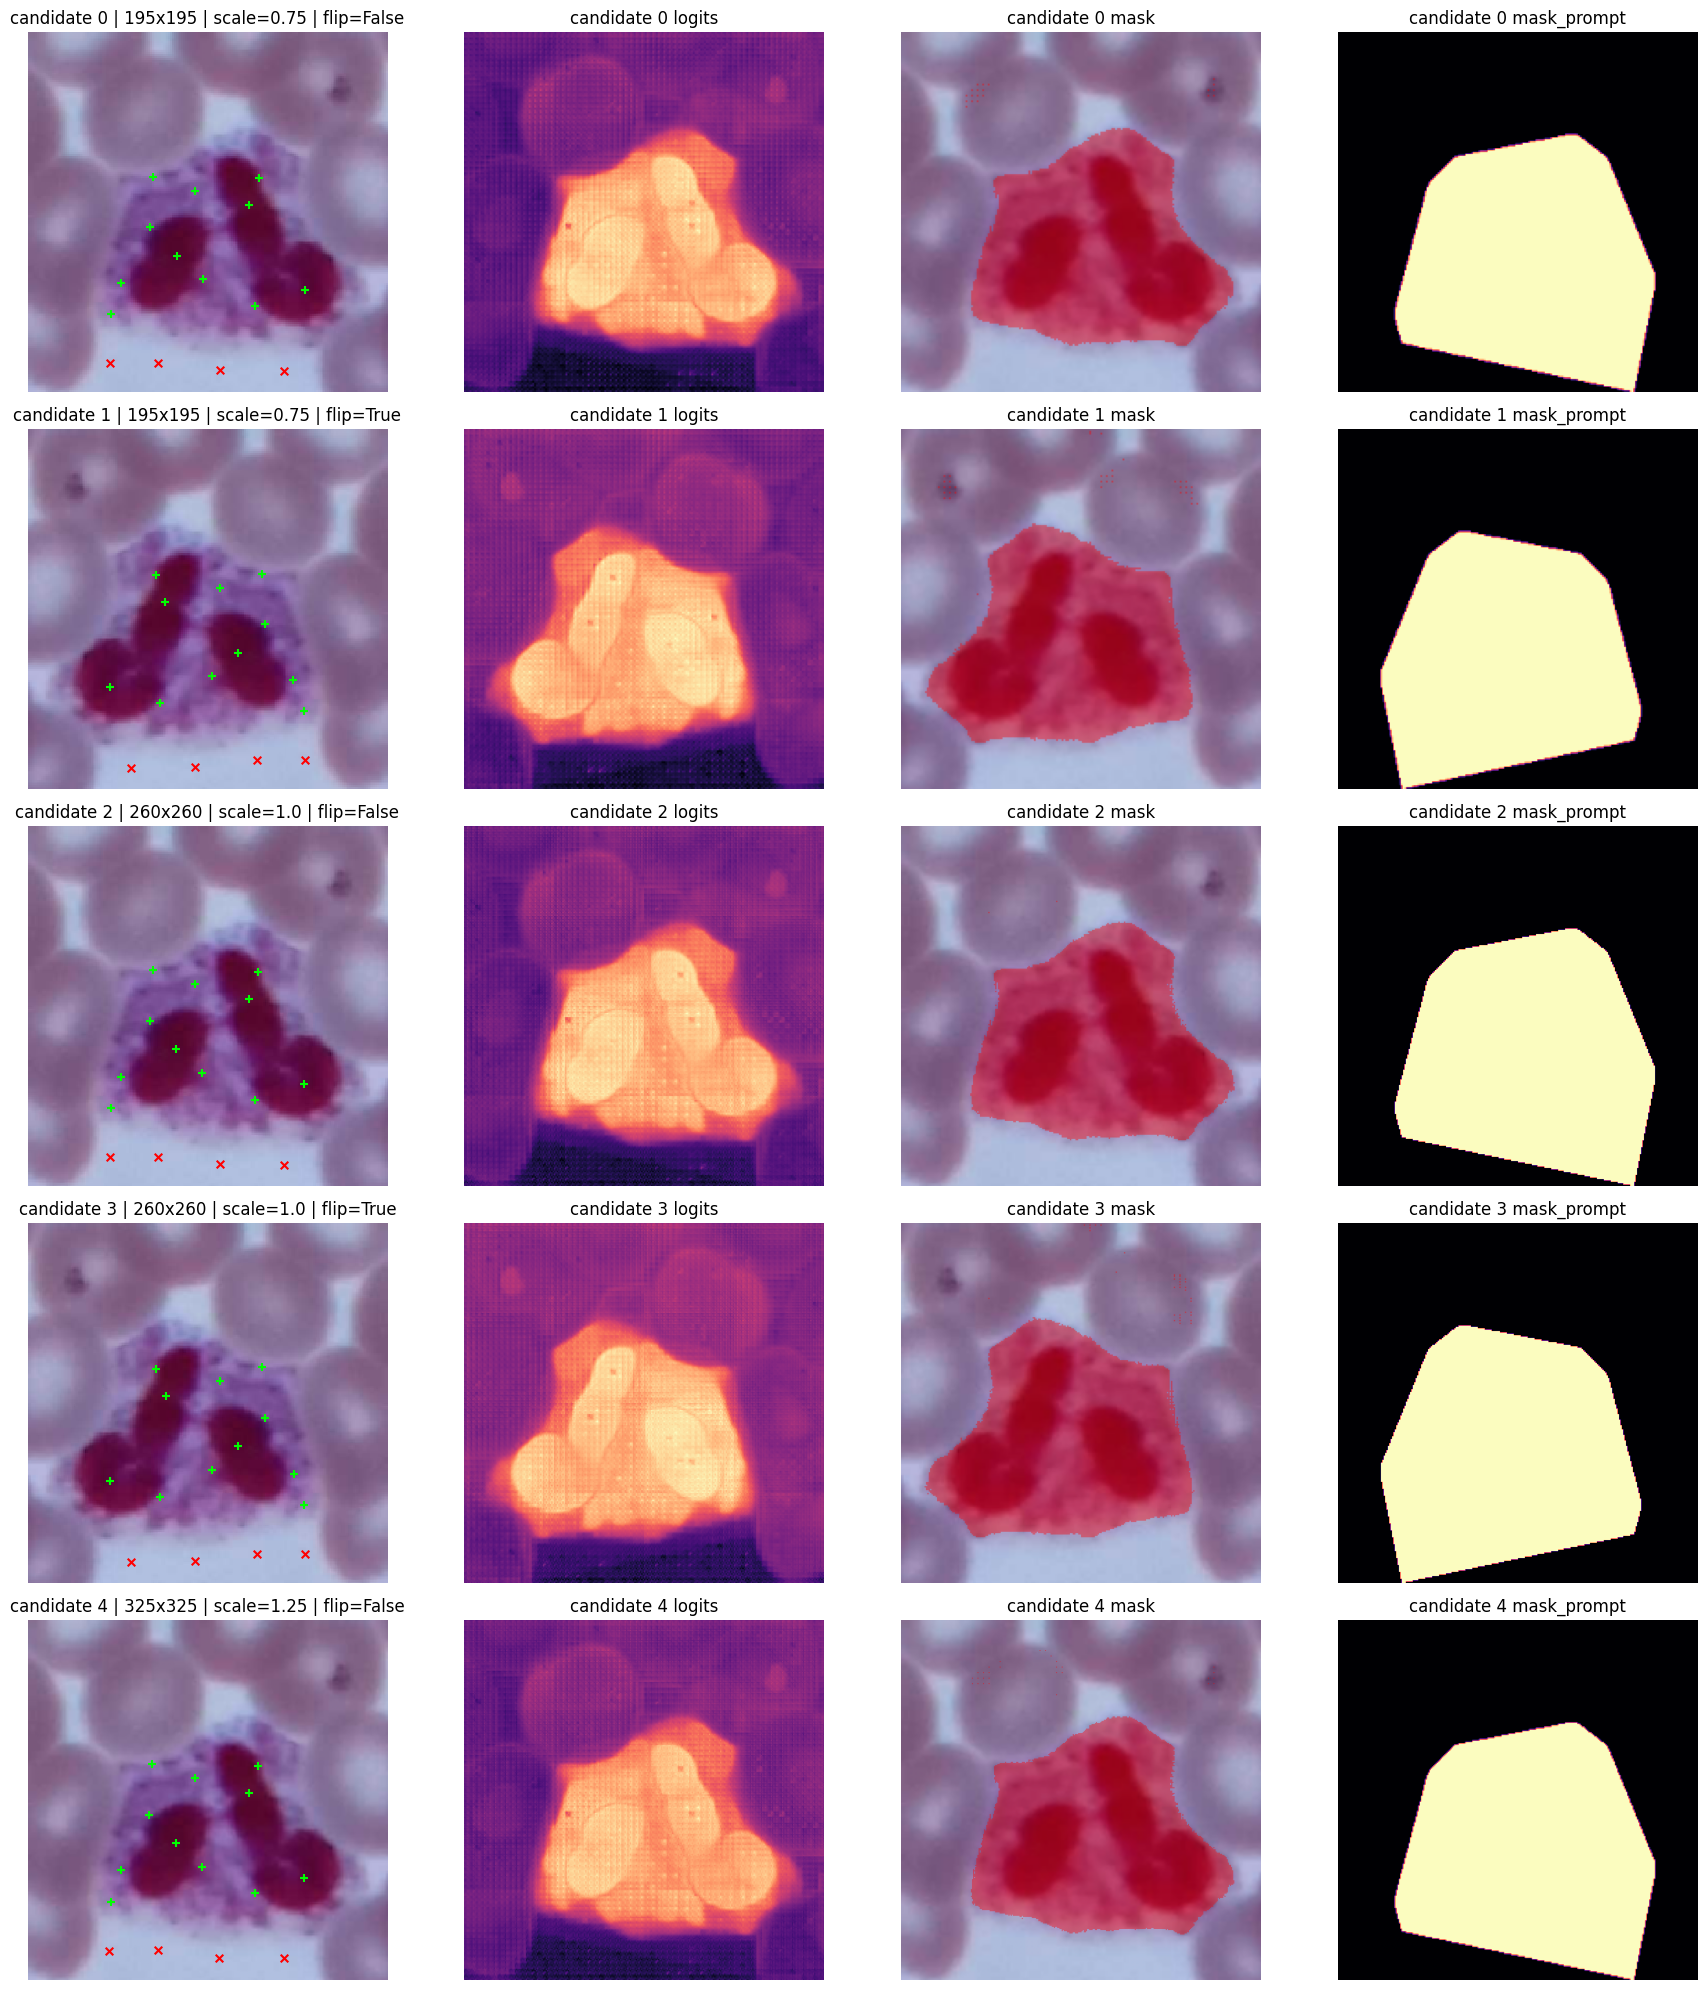

In [8]:
# 2) Candidate/augmentation grid: left=aug image+mapped prompts, middle=logits heatmap, right=mask overlay + mask_prompt
augment_fn = default_multi_view_augment(
    scales=tta_cfg["augment"]["scales"],
    do_flip=tta_cfg["augment"]["use_flip"],
    views_per_step=int(tta_cfg["augment"].get("views_per_step", 2)),
)
views = augment_fn(vis_image)

fig, axes = plt.subplots(len(views), 4, figsize=(18, 4 * len(views)))
if len(views) == 1:
    axes = np.expand_dims(axes, axis=0)

for idx, (img_aug, transform_view) in enumerate(views):
    h, w = img_aug.shape[:2]
    mapped_vis = prepare_prompts_for_vis(transform_view, prompts)
    mapped_model = prepare_prompts_for_model(transform_view, prompts)

    axes[idx, 0].imshow(_to_uint8(img_aug), interpolation="nearest")
    _draw_points(axes[idx, 0], mapped_vis["point_coords"], mapped_vis["point_labels"])
    axes[idx, 0].set_title(f"candidate {idx} | {h}x{w} | scale={transform_view.scale} | flip={transform_view.flip}")
    axes[idx, 0].axis("off")

    predictor.set_image(img_aug)
    logits, _, _ = predictor.predict(
        point_coords=mapped_model["point_coords"],
        point_labels=mapped_model["point_labels"],
        box=mapped_model["box"],
        mask_input=mapped_model["mask_input"],
        multimask_output=mapped_model["multimask_output"],
        return_logits=True,
    )
    heat = logits[0]
    _show_heatmap(axes[idx, 1], heat, f"candidate {idx} logits")

    mask = heat > 0
    overlay = _overlay(img_aug, mask)
    axes[idx, 2].imshow(overlay)
    axes[idx, 2].set_title(f"candidate {idx} mask")
    axes[idx, 2].axis("off")

    if mapped_vis["mask_input"] is not None:
        _show_heatmap(axes[idx, 3], mapped_vis["mask_input"], f"candidate {idx} mask_prompt")
    else:
        axes[idx, 3].text(0.5, 0.5, "None", ha="center", va="center")
        axes[idx, 3].set_title(f"candidate {idx} mask_prompt")
        axes[idx, 3].axis("off")

plt.tight_layout()
plt.show()


# Part 4: run tta

In [9]:
# 3) Run TTA steps with real model, collect losses + outputs
tta_loss_weights = TTALossWeights(
    anchor=float(tta_cfg["loss_weights"]["anchor"]),
    entropy=float(tta_cfg["loss_weights"]["entropy"]),
    consistency=float(tta_cfg["loss_weights"]["consistency"]),
    regularization=float(tta_cfg["loss_weights"].get("regularization", 0.0)),
)

def _optimizer_step(total_loss, _losses):
    if optimizer is None:
        return
    if not isinstance(total_loss, torch.Tensor) or not total_loss.requires_grad:
        return
    optimizer.zero_grad(set_to_none=True)
    total_loss.backward()
    if max_grad_norm > 0:
        nn.utils.clip_grad_norm_(trainable_params, max_grad_norm)
    optimizer.step()

step_outputs = []
step_losses = []
for step in range(int(tta_cfg.get("tta_steps", 3))):
    tta_out = run_tta_from_pool(
        predictor,
        vis_image,
        info.get_mask_pool(),
        prompts,
        loss_weights=tta_loss_weights,
        selection_strategy=tta_cfg.get("pseudo_label", {}).get("strategy", "score_top_k"),
        top_k=int(tta_cfg.get("pseudo_label", {}).get("top_k_masks", 3)),
        augment_fn=augment_fn,
        optimizer_step_fn=_optimizer_step,
    )
    step_outputs.append(tta_out["tta_outputs"])
    step_losses.append({"step": step + 1, **{k: float(v) for k, v in tta_out["tta_outputs"].losses.items()}})

print(json.dumps(step_losses, indent=2))


[
  {
    "step": 1,
    "supervision": 0.22100231051445007,
    "entropy": 0.044988200068473816,
    "consistency": 0.1758713275194168,
    "total": 0.4418618083000183
  },
  {
    "step": 2,
    "supervision": 0.214291512966156,
    "entropy": 0.04422914981842041,
    "consistency": 0.1739834100008011,
    "total": 0.4325040578842163
  },
  {
    "step": 3,
    "supervision": 0.20695269107818604,
    "entropy": 0.04337698221206665,
    "consistency": 0.1719183474779129,
    "total": 0.4222480058670044
  }
]


# Part 5: final output

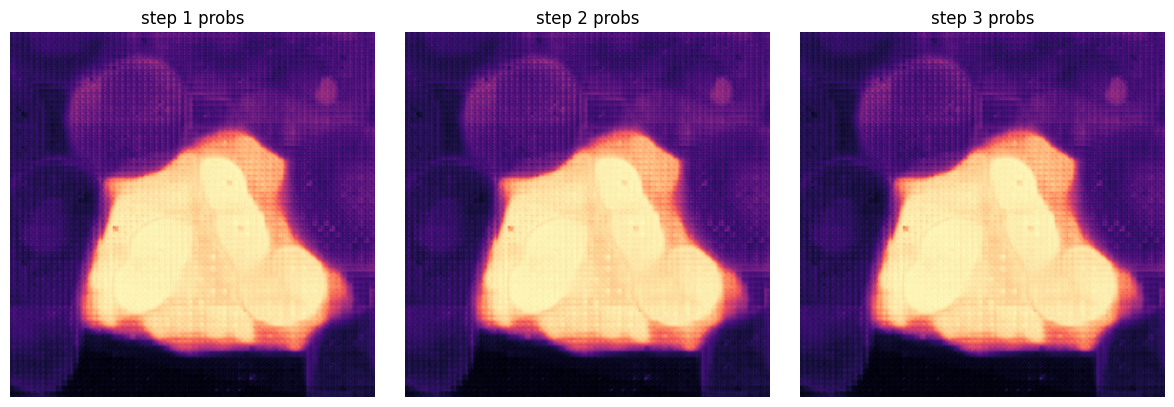

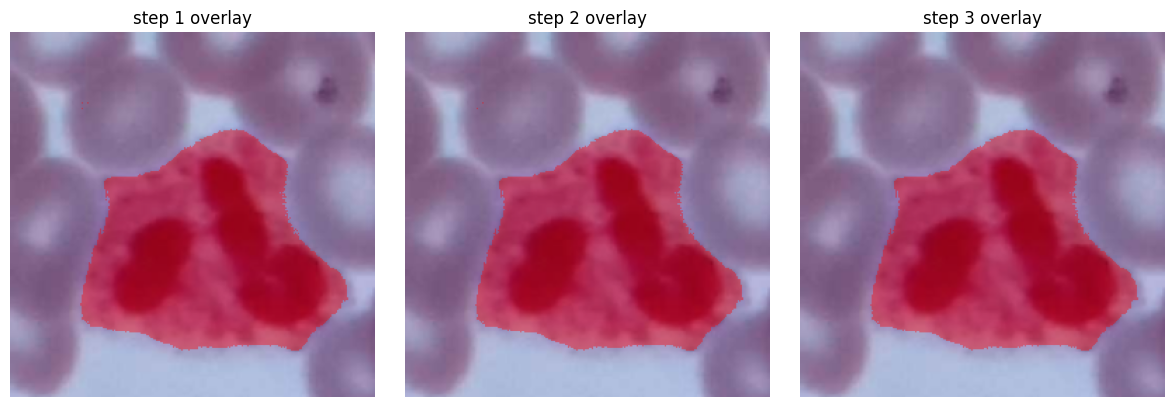

In [10]:
# 4) Prediction evolution (step1 -> step3)
prob_maps = []
overlays = []

for out in step_outputs:
    probs = out.student_probs
    if hasattr(probs, "detach"):
        probs = probs.detach().cpu().numpy()
    if probs.ndim == 3 and probs.shape[0] == 1:
        probs = probs[0]
    prob_maps.append(probs)
    overlays.append(_overlay(vis_image, probs > 0.5))

fig, axes = plt.subplots(1, len(prob_maps), figsize=(4 * len(prob_maps), 4))
if len(prob_maps) == 1:
    axes = [axes]
for idx, probs in enumerate(prob_maps, start=1):
    axes[idx - 1].imshow(probs, cmap="magma")
    axes[idx - 1].set_title(f"step {idx} probs")
    axes[idx - 1].axis("off")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(overlays), figsize=(4 * len(overlays), 4))
if len(overlays) == 1:
    axes = [axes]
for idx, overlay in enumerate(overlays, start=1):
    axes[idx - 1].imshow(overlay)
    axes[idx - 1].set_title(f"step {idx} overlay")
    axes[idx - 1].axis("off")
plt.tight_layout()
plt.show()
